Here we train the convolutional neural network:
We require the following folders:
- DataFiltered: contains the filtered data by class and augmented (see filter.ipynb)
- labels_upsampled.csv: contains the labels of the data

What we first do is filter the data into training, test and validation sets. 

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import PIL
import seaborn as sns
import random

We filter the data into train/val/test in ratio 80|10|10.

In [17]:
labeling = pd.read_csv('C:/Users/Frank/Documents/GitHub/AI_V3_MULTI/preprocess/trainvaltestOG/trainvaltestcsv/all_labeling.csv')
labeling

,filename,item_type,label
0,100_i110.png,100,plastic
1,100_i120.png,100,plastic
2,100_i130.png,100,plastic
3,100_i140.png,100,plastic
4,100_i150.png,100,plastic
...,...,...,...
7747,997_i180.png,997,plastic
7748,997_i190.png,997,plastic
7749,997_i210.png,997,plastic
7750,997_i230.png,997,plastic


In [18]:
unique_item_type = labeling['item_type'].unique()

In [19]:
#seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [20]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [12]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [21]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [22]:
csv_file_label = "C:/Users/Frank/Documents/GitHub/AI_V3_MULTI/preprocess/trainvaltestOG/trainvaltestcsv/all_labeling.csv"

In [23]:
target_dir = "C:/Users/Frank/Documents/GitHub/AI_V3_MULTI/preprocess/trainvaltestOG/"

In [24]:
Top4Dataset_train = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file=csv_file_label, root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 6192
length of val dataset: 780
length of test dataset: 780


In [25]:
batch_count = 8

In [26]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=batch_count, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=batch_count, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=batch_count, shuffle=True)

In [27]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

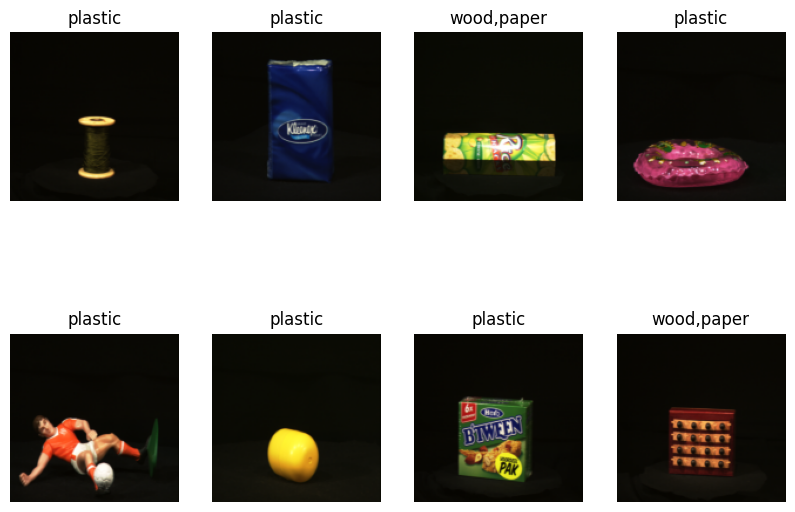

In [14]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(batch_count):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(label_list[labels[i].argmax()])
    plt.axis("off")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(10368, 3),
        )

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

Using cuda device
ConvNeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=10368, out_features=3, bias=True)
  )
)


In [16]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y, path) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)

In [17]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.losshistory = []
        self.trainlosshistory = []
        self.best_epoch = 0
        self.best_results = {"test_loss": np.inf, "train_loss": np.inf}

    def early_stop(self, validation_loss, train_loss, nnmodel):
        self.losshistory.append(validation_loss)
        self.trainlosshistory.append(train_loss)
        if validation_loss < self.min_validation_loss:
            self.best_epoch = len(self.losshistory)
            torch.save(model.state_dict(), "./modelsOG/model_" + str(self.best_epoch) + ".pt")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_results["test_loss"] = validation_loss
            self.best_results["train_loss"] = train_loss
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
#remove directory for saving model
if os.path.exists("modelsOG"):
    shutil.rmtree("modelsOG")
#make directory for saving model
if not os.path.exists("modelsOG"):
    os.mkdir("modelsOG")

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [20]:
DataLoader_train.dataset.label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [21]:
#model parameters
learning_rate = 1e-3
epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [22]:
#create early stopper (recall it if you want to reset the training history)
early_stopping = EarlyStopper( patience=2, min_delta=0.0001)

In [23]:
#train model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(DataLoader_train, model, loss_fn, optimizer)
    test_loss = test(DataLoader_test, model, loss_fn)
    print(f"Train Loss: {train_loss}")
    early_stopping.early_stop(test_loss, train_loss, model)
    #if early_stopping.early_stop(test_loss, train_loss, model):
        #print("Early stopping")
        #break
print("Done!")

Epoch 1
-------------------------------
loss: 1.097546  [    0/ 6192]
loss: 0.787451  [  800/ 6192]
loss: 0.944906  [ 1600/ 6192]
loss: 0.818775  [ 2400/ 6192]
loss: 1.053590  [ 3200/ 6192]
loss: 0.857022  [ 4000/ 6192]
loss: 0.948604  [ 4800/ 6192]
loss: 1.071462  [ 5600/ 6192]
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.003310 

Train Loss: 0.9603361579028827
Epoch 2
-------------------------------
loss: 0.897655  [    0/ 6192]
loss: 1.011921  [  800/ 6192]
loss: 0.952097  [ 1600/ 6192]
loss: 0.930624  [ 2400/ 6192]
loss: 0.757892  [ 3200/ 6192]
loss: 0.751987  [ 4000/ 6192]
loss: 1.144706  [ 4800/ 6192]
loss: 1.163458  [ 5600/ 6192]
Test Error: 
 Accuracy: 55.4%, Avg loss: 0.993675 

Train Loss: 0.9444478699403216
Epoch 3
-------------------------------
loss: 0.914029  [    0/ 6192]
loss: 0.595909  [  800/ 6192]
loss: 0.874229  [ 1600/ 6192]
loss: 1.195868  [ 2400/ 6192]
loss: 1.229710  [ 3200/ 6192]
loss: 0.873166  [ 4000/ 6192]
loss: 0.706420  [ 4800/ 6192]
loss: 0.774154  [ 5600/ 

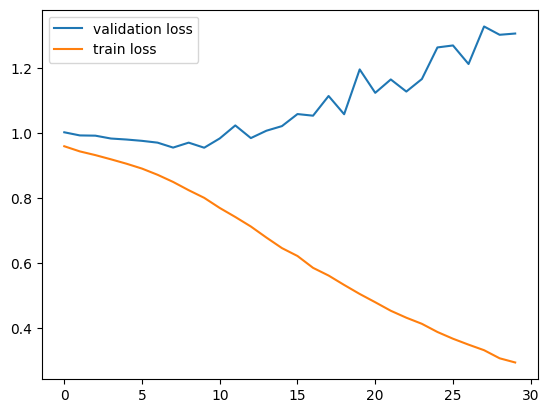

In [24]:
plt.plot(early_stopping.losshistory, label='validation loss')
plt.plot(early_stopping.trainlosshistory, label='train loss')
plt.legend()

In [39]:
#store the chart data as a csv file
chart_df = pd.DataFrame({"epoch": range(1, len(early_stopping.losshistory)+1), "test_loss": early_stopping.losshistory,  "train_loss": early_stopping.trainlosshistory})
chart_df.to_csv("./modelsOG/chart.csv", index=False)

In [8]:
#load best model (minimum test loss and last epoch)
for best_epoch in range(1, 30):
    if os.path.exists("./modelsOG/model_" + str(best_epoch) + ".pt"):
        model.load_state_dict(torch.load("./modelsOG/model_" + str(best_epoch) + ".pt"))
        print("Best model loaded at epoch " + str(best_epoch))

Best model loaded at epoch 1
Best model loaded at epoch 2
Best model loaded at epoch 3
Best model loaded at epoch 4
Best model loaded at epoch 5
Best model loaded at epoch 6
Best model loaded at epoch 7
Best model loaded at epoch 8
Best model loaded at epoch 10


In [10]:
def predict_image(img, model):
    xb = img
    xb = transforms.Resize((144,144))(xb)
    xb = transforms.ToTensor()(xb)
    xb = xb.unsqueeze(0)
    xb = xb.to(device)
    xb = xb.float()
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [13]:
material_label

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

In [14]:
def confusionMatrix(model, path, material_label):
    confusion_matrix = torch.zeros(3, 3)
    with torch.no_grad():
        for file in os.listdir(path):
            img_path = file
            img = PIL.Image.open(path + img_path)
            label = labeling[labeling["filename"] == img_path]["label"].values[0]
            nr_label = material_label.get(label)
            pred = predict_image(img, model)
            confusion_matrix[nr_label, pred] += 1
    return confusion_matrix

In [28]:
data_path = "C:/Users/Frank/Documents/GitHub/AI_V3_MULTI/preprocess/trainvaltestOG/"
train_path = data_path + "train/"
val_path = data_path + "val/"
test_path = data_path + "test/"
test_conf_mat = confusionMatrix(model, test_path, DataLoader_test.dataset.label)
val_conf_mat = confusionMatrix(model, val_path, DataLoader_val.dataset.label)
train_conf_mat = confusionMatrix(model, train_path, DataLoader_train.dataset.label)

Text(1986.8986928104575, 0.5, 'Actual')

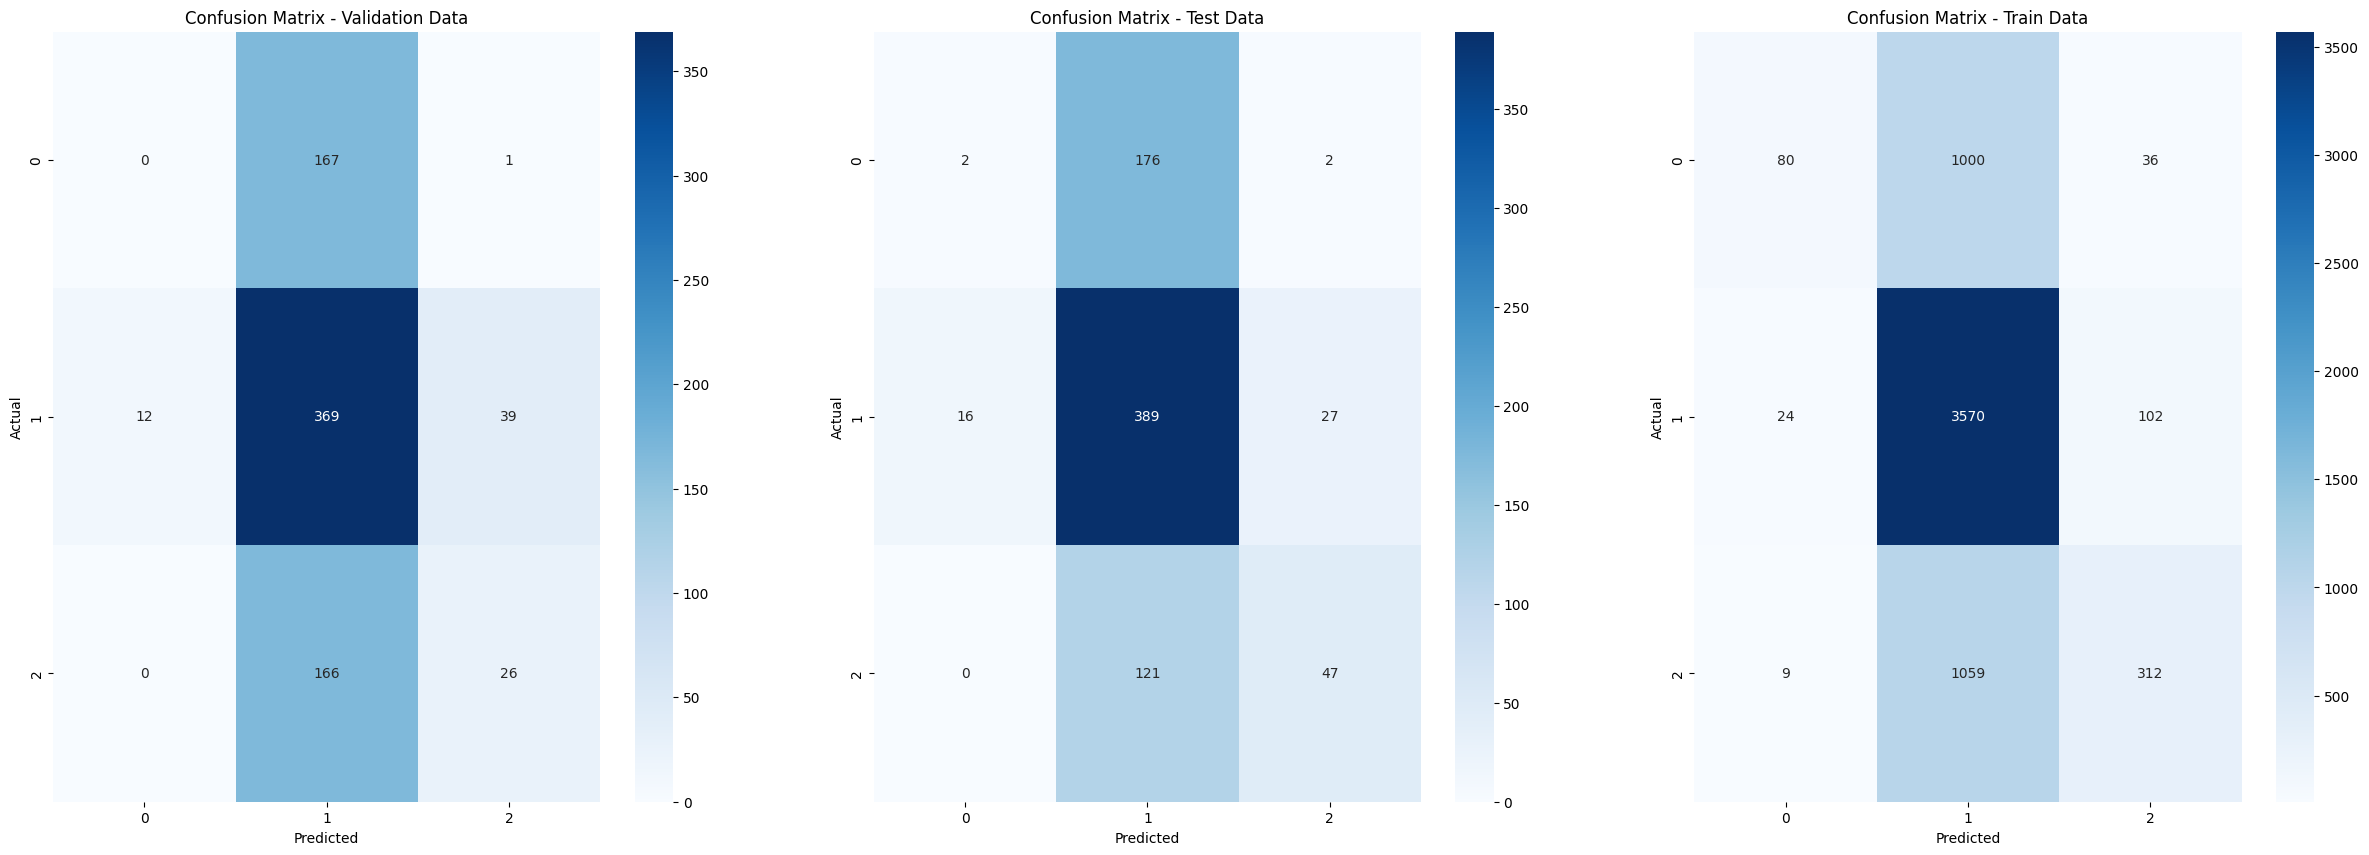

In [29]:
#plot confusion matrix
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.title("Confusion Matrix - Validation Data")
sns.heatmap(val_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1,3,2)
plt.title("Confusion Matrix - Test Data")
sns.heatmap(test_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1,3,3)
plt.title("Confusion Matrix - Train Data")
sns.heatmap(train_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')



In [30]:
#f1 score
def f1_score(confusion_matrix):
    f1_score = 0
    for i in range(3):
        tp = confusion_matrix[i,i]
        fn = confusion_matrix[i,:].sum() - tp
        fp = confusion_matrix[:,i].sum() - tp
        f1_score += 2*tp/(2*tp + fp + fn)
    return f1_score/3

In [48]:
f1_score_train = f1_score(train_conf_mat)
f1_score_val = f1_score(val_conf_mat)
f1_score_test = f1_score(test_conf_mat)
print("F1 score train: ", f1_score_train.item())
print("F1 score val: ", f1_score_val.item())
print("F1 score test: ", f1_score_test.item())

F1 score train:  0.41228482127189636
F1 score val:  0.2864347994327545
F1 score test:  0.3671111762523651


In [32]:
#accuracy over original dataset
original_dataset = "C:/Users/Frank/Documents/GitHub/AI_V3_MULTI/preprocess/Filtered/"
original_dataset_label = "C:/Users/Frank/Documents/GitHub/AI_V3_MULTI/preprocess/Original_Labels.csv"

In [ ]:
original_dataset_label_df = pd.read_csv(original_dataset_label)

In [ ]:
#predict labels
original_dataset_label_df["predicted_label"] = original_dataset_label_df["filename"].apply(lambda x: predict_image(PIL.Image.open(original_dataset + x), model))

In [ ]:
original_dataset_label_df["actual_label"] = original_dataset_label_df["label"].apply(lambda x: DataLoader_train.dataset.label.get(x))

In [ ]:
#calculate accuracy
accuracy = (original_dataset_label_df["predicted_label"] == original_dataset_label_df["actual_label"]).sum() / len(original_dataset_label_df)

In [ ]:
accuracy

0.6213880288957688